---


## 2021-02-16


---

# 06-1 군집 알고리즘
- 비지도 학습, 히스토그램, 군집
- 흑백 사진을 분류하기 위해 여러 가지 아이디어를 내면서 비지도 학습과 군집 알고리즘에 대해 이해


## 타깃을 모르는 비지도 학습
- 비지도 학습 (unsupervised learning)


## 과일 사진 데이터 준비하기

In [2]:
import numpy as np
import matplotlib.pyplot as plt

fruits = np.load('fruits_300.npy')

In [3]:
print(fruits.shape)

(300, 100, 100)


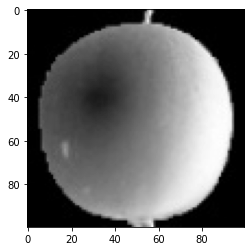

In [4]:
plt.imshow(fruits[0], cmap='gray')
plt.show()

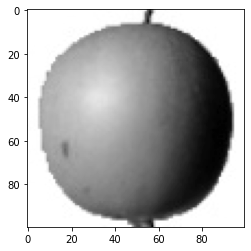

In [5]:
plt.imshow(fruits[0], cmap='gray_r')
plt.show()

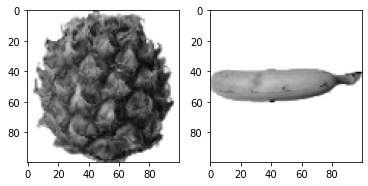

In [6]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(fruits[100], cmap='gray_r')
axs[1].imshow(fruits[200], cmap='gray_r')
plt.show()

- subplots() 함수를 사용하면 여러 개의 그래프를 배열처럼 쌓을 수 있도록 도와줌


## 픽셀값 분석하기
- 100x100 이미지를 길이가 10,000인 1차원 배열로 만듬

In [7]:
apple = fruits[0:100].reshape(-1, 100*100)
pineapple = fruits[100:200].reshape(-1, 100*100)
banana = fruits[200:300].reshape(-1, 100*100)

In [8]:
print(apple.shape)

(100, 10000)


In [9]:
print(apple.mean(axis = 1))

[ 88.3346  97.9249  87.3709  98.3703  92.8705  82.6439  94.4244  95.5999
  90.681   81.6226  87.0578  95.0745  93.8416  87.017   97.5078  87.2019
  88.9827 100.9158  92.7823 100.9184 104.9854  88.674   99.5643  97.2495
  94.1179  92.1935  95.1671  93.3322 102.8967  94.6695  90.5285  89.0744
  97.7641  97.2938 100.7564  90.5236 100.2542  85.8452  96.4615  97.1492
  90.711  102.3193  87.1629  89.8751  86.7327  86.3991  95.2865  89.1709
  96.8163  91.6604  96.1065  99.6829  94.9718  87.4812  89.2596  89.5268
  93.799   97.3983  87.151   97.825  103.22    94.4239  83.6657  83.5159
 102.8453  87.0379  91.2742 100.4848  93.8388  90.8568  97.4616  97.5022
  82.446   87.1789  96.9206  90.3135  90.565   97.6538  98.0919  93.6252
  87.3867  84.7073  89.1135  86.7646  88.7301  86.643   96.7323  97.2604
  81.9424  87.1687  97.2066  83.4712  95.9781  91.8096  98.4086 100.7823
 101.556  100.7027  91.6098  88.8976]


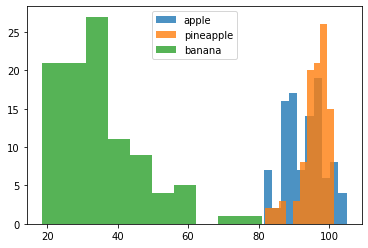

In [10]:
plt.hist(np.mean(apple, axis = 1), alpha = 0.8)
plt.hist(np.mean(pineapple, axis = 1), alpha = 0.8)
plt.hist(np.mean(banana, axis = 1), alpha = 0.8)
plt.legend(['apple', 'pineapple', 'banana'])
plt.show()

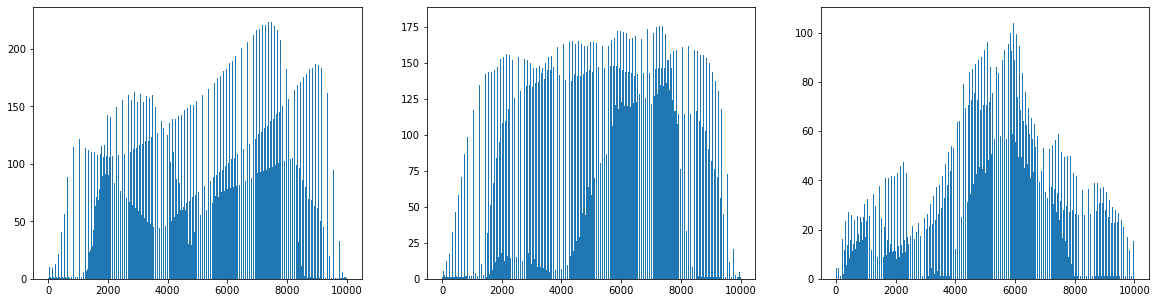

In [11]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
axs[0].bar(range(10000), np.mean(apple, axis = 0))
axs[1].bar(range(10000), np.mean(pineapple, axis = 0))
axs[2].bar(range(10000), np.mean(banana, axis = 0))
plt.show()

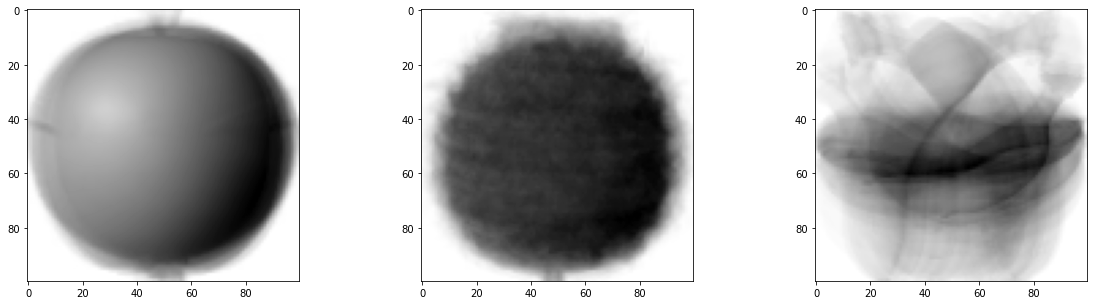

In [13]:
apple_mean = np.mean(apple, axis = 0).reshape(100, 100)
pineapple_mean = np.mean(pineapple, axis = 0).reshape(100, 100)
banana_mean = np.mean(banana, axis = 0).reshape(100, 100)
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
axs[0].imshow(apple_mean, cmap = 'gray_r')
axs[1].imshow(pineapple_mean, cmap = 'gray_r')
axs[2].imshow(banana_mean, cmap = 'gray_r')
plt.show()

## 평균값과 가까운 사진 고르기

In [15]:
abs_diff = np.abs(fruits - apple_mean)
abs_mean = np.mean(abs_diff, axis = (1, 2))
print(abs_mean.shape)

(300,)


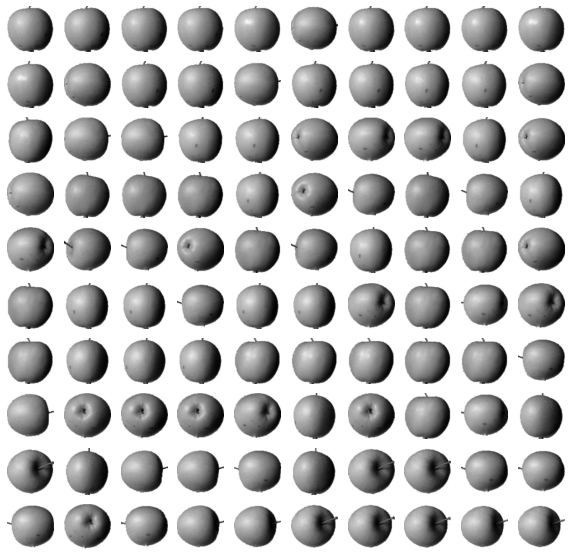

In [19]:
apple_index = np.argsort(abs_mean)[:100]
fig, axs = plt.subplots(10, 10, figsize = (10, 10))
for i in range(10):
    for j in range(10):
        axs[i, j].imshow(fruits[apple_index[i*10 + j]], cmap = 'gray_r')
        axs[i, j].axis('off')
plt.show()

- 흑백 사진에 있는 픽셀값을 사용해 과일 사진을 모으는 작업
- **군집**: 비슷한 샘플끼리 그룹으로 모으는 작업
- **클러스터**: 군집 알고리즘에서 만든 그룹


- 타깃값을 모르면서 어떻게 세 과일의 평균값을 찾을 수 있을까? --> **k-평균 알고리즘**


## 비슷한 샘플끼리 모으기
- 타깃값이 없을 때 데이터에 있는 패턴을 찾거나 데이터 구조를 파악하는 머신러닝 방식을 비지도 학습이라 함


---


# 06-2 k-평균
- k-평균, 클러스터 중심, 엘보우 방법
- k-평균 알고리즘의 작동 방식을 이해하고 과일 사진을 자동으로 모으는 비지도 학습 모델을 만들어 봄
- k-평균 알고리즘이 평균값을 자동으로 찾아줌 --> 이 평균값을 'cluster center' or 'centroid'라 부름


## k-평균 알고리즘 소개
1. 무작위로 k개의 클러스터 중심을 정함
2. 각 샘플에서 가장 가까운 클러스터 중심을 찾아 해당 클러스터의 샘플로 지정
3. 클러스터에 속한 샘플의 평균값으로 클러스터 중심을 변경
4. 클러스터 중심에 변화가 없을 때까지 2번으로 돌아가 반복


## KMeans Class

In [20]:
import numpy as np
fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100)

In [21]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3, random_state = 42)
km.fit(fruits_2d)

KMeans(n_clusters=3, random_state=42)

In [22]:
print(km.labels_)

[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [23]:
print(np.unique(km.labels_, return_counts=True))

(array([0, 1, 2]), array([ 91,  98, 111], dtype=int64))


In [28]:
import matplotlib.pyplot as plt
def draw_fruits(arr, ratio = 1):
    n = len(arr)
    rows = int(np.ceil(n / 10))
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols, figsize = (cols * ratio, rows * ratio), squeeze = False)
    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:
                axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
            axs[i,j].axis('off')
    plt.show()

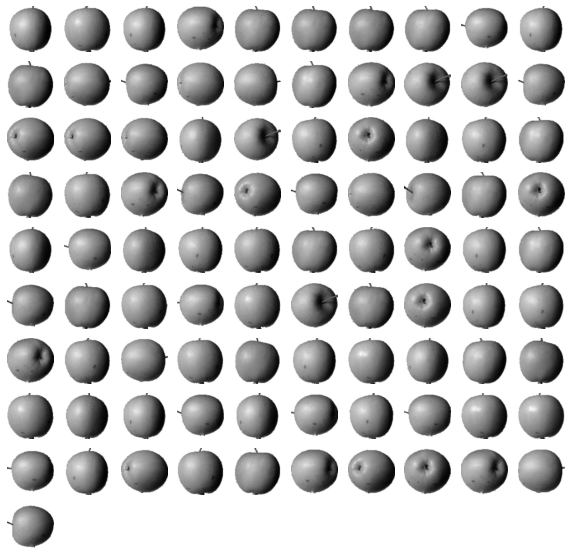

In [29]:
draw_fruits(fruits[km.labels_==0])

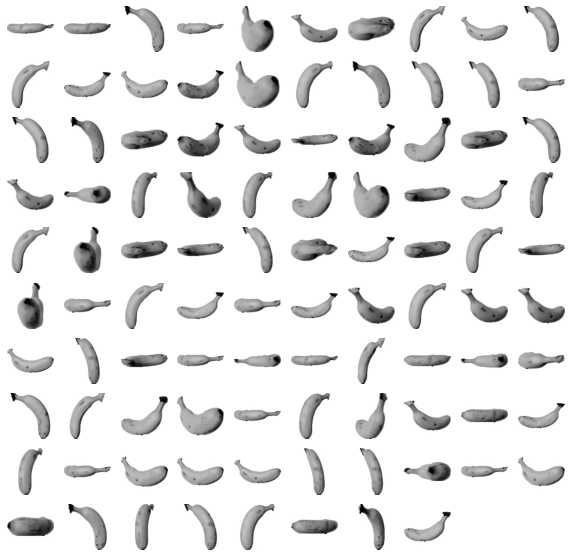

In [30]:
draw_fruits(fruits[km.labels_==1])

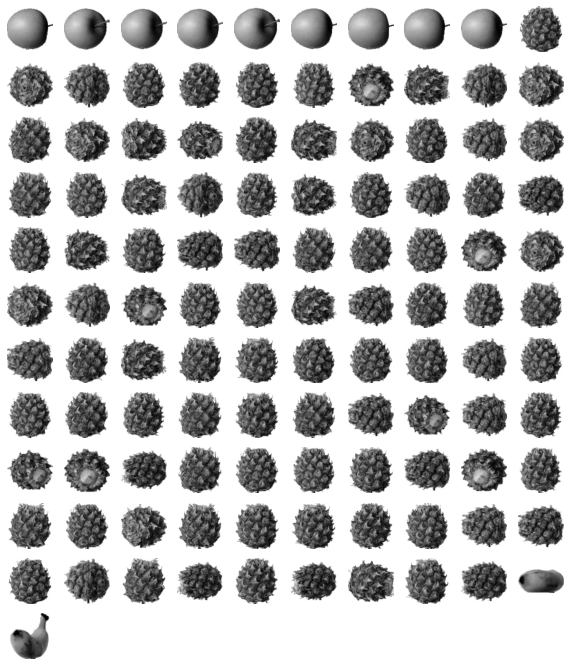

In [31]:
draw_fruits(fruits[km.labels_==2])

## 클러스터 중심

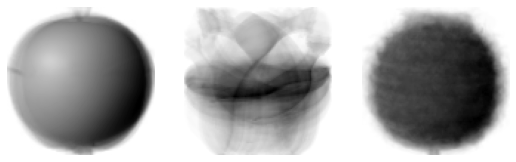

In [32]:
draw_fruits(km.cluster_centers_.reshape(-1, 100, 100), ratio=3)

In [33]:
print(km.transform(fruits_2d[100:101]))

[[5267.70439881 8837.37750892 3393.8136117 ]]


In [34]:
print(km.predict(fruits_2d[100:101]))

[2]


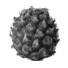

In [35]:
draw_fruits(fruits[100:101])

In [36]:
print(km.n_iter_)

3


## 최적의 k 찾기
- 최대 단점 중 하나가 클러스터 개수를 지정해야 한다는 것
- 그럼 어떻게 적절한 k 값을 찾음?
- elbow method
- inertia : 클러스터 중심과 클러스터에 속한 샘플 사이의 거리의 제곱 합 --> 클러스터에 속한 샘플이 얼마나 가깝게 모여 있는지를 나타내는 값
- 일반적으로 클러스터 개수가 늘어나면 클러스터 개개의 크기는 줄어들기 때문에 inertia도 줄어듬
- 클러스터 개수를 증가시키면서 inertia를 그래프로 그리면 감소하는 속도가 꺾이는 지점 존재
- 이 지점 부터 클래스터 개수를 늘려도 클래스터에 잘 밀집된 정도가 크게 개선되지 않음
- 팔꿈치 모양처럼 꺾여서 elbow 방법이라 함

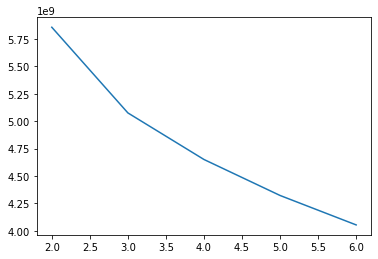

In [37]:
inertia = []
for k in range(2, 7):
    km = KMeans(n_clusters = k, random_state = 42)
    km.fit(fruits_2d)
    inertia.append(km.inertia_)
plt.plot(range(2, 7), inertia)
plt.show()

- k=3에서 꺾이는 것 확인

# 06-3 주성분 분석
- 차원 축소, 주성분 분석, 설명된 분산
- 차원 축소에 대해 이해하고 대표적인 차원 축소 알고리즘 중 하나인 PCA 모델을 만들어 봄


## 차원과 차원 축소
- 차원 축소: 데이터를 가장 잘 나타내는 일부 특성을 선택하여 데이터 크기를 줄이고 지도 학습 모델의 성능을 향상시킬 수 있는 방법
- 줄어든 차원에서 다시 원본 차원으로 손실을 최대한 줄이면서 복원할 수도 있음
- PCA: principal component anaylsis


## 주성분 분석 소개
- 데이터에 있는 분산이 큰 방향을 찾는 것!
- 주성분 벡터는 원본 데이터에 있는 어떤 방향
- 주성분은 원본 차원과 같고 주성분으로 바꾼 데이터는 차원이 줄어듬!


## PCA Class

In [38]:
fruits_2d = fruits.reshape(-1, 100*100)
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(fruits_2d)

PCA(n_components=50)

In [39]:
print(pca.components_.shape)

(50, 10000)


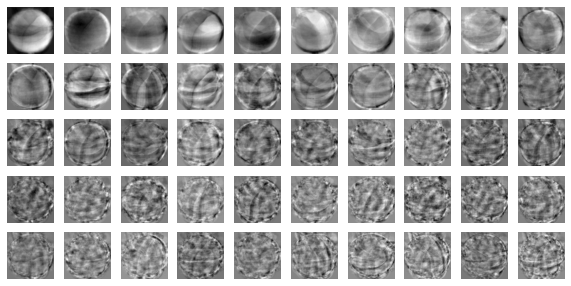

In [40]:
draw_fruits(pca.components_.reshape(-1, 100, 100))

In [41]:
print(fruits_2d.shape)

(300, 10000)


In [42]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 50)


## 원본 데이터 재구성

In [43]:
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


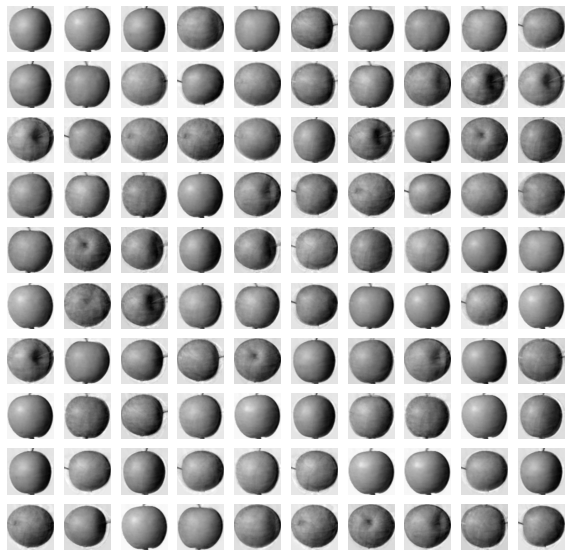

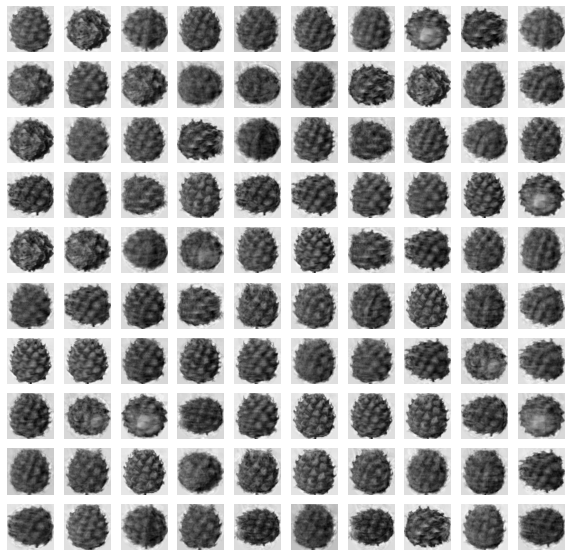

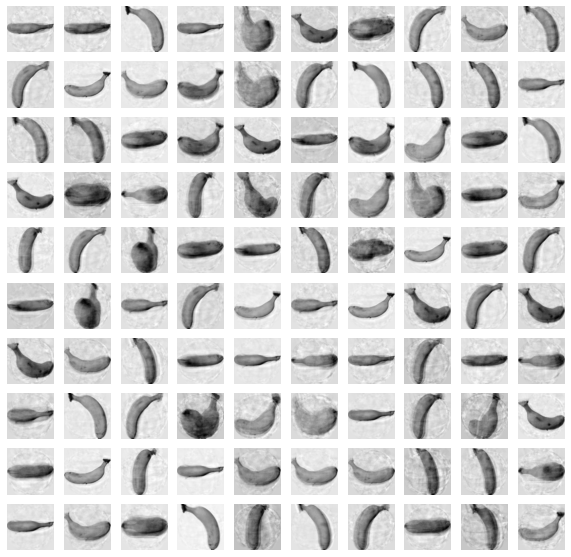

In [44]:
fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)
for start in [0, 100, 200]:
    draw_fruits(fruits_reconstruct[start:start+100])
    print("\n")

## 설명된 분산
- 주성분이 원본 데이터의 분산을 얼마나 잘 나타내는지 기록한 값

In [45]:
print(np.sum(pca.explained_variance_ratio_))

0.9214157615329971


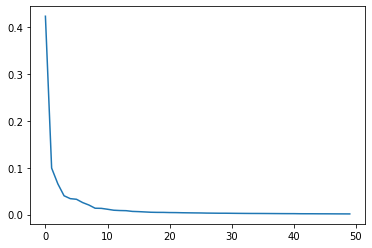

In [46]:
plt.plot(pca.explained_variance_ratio_)

## 다른 알고리즘과 함께 사용하기

In [47]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [48]:
target = np.array([0]*100 + [1]*100 + [2]*100)

In [49]:
from sklearn.model_selection import cross_validate
scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9966666666666667
0.3520978927612305


In [50]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

1.0
0.023888254165649415


In [51]:
pca = PCA(n_components=0.5)
pca.fit(fruits_2d)

PCA(n_components=0.5)

In [52]:
print(pca.n_components_)

2


In [53]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [54]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9933333333333334
0.03388423919677734


C:\Users\bok_suh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\bok_suh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

In [55]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)
print(np.unique(km.labels_, return_counts=True))

(array([0, 1, 2]), array([110,  99,  91], dtype=int64))


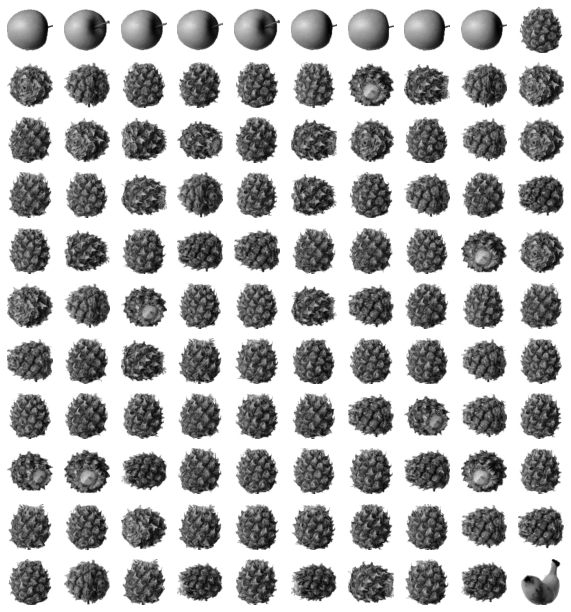

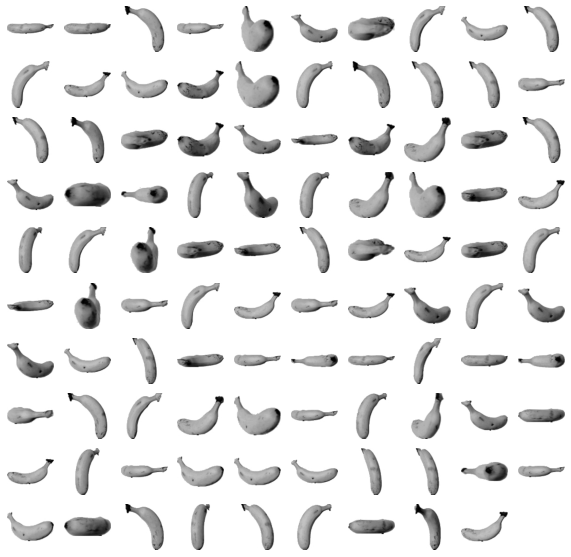

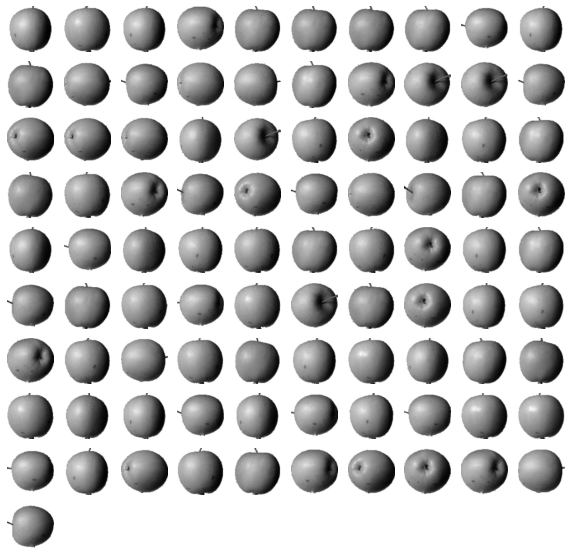

In [56]:
for label in range(0, 3):
    draw_fruits(fruits[km.labels_ == label])
    print("\n")

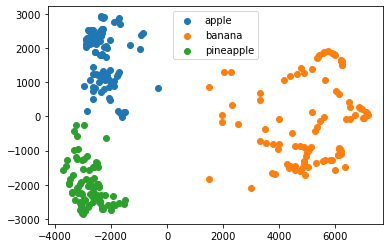

In [57]:
for label in range (0, 3):
    data = fruits_pca[km.labels_ == label]
    plt.scatter(data[:,0], data[:,1])
plt.legend(['apple', 'banana', 'pineapple'])
plt.show()

## 주성분 분석으로 차원 축소
- 차원 축소를 사용하면 데이터셋의 크기를 줄일 수 있고 시각화하기 쉬움
- 앞에서 PCA로 특성을 50개로 크게 줄임
- 주성분의 개수를 명시적으로 지정하는 대신 설명된 분산의 비율을 설정하여 원하는 비율만큼 주성분을 찾을 수 있음